In [68]:
import pandas as pd

# Read train data into data frame
train_data_frame = pd.read_csv('TrainData.csv')
print(train_data_frame.shape)
print(train_data_frame.head())

(6966, 2)
                                                text   emotion
0  b'#Dutch @TUDelft researchers teach #selfdrivi...   neutral
1  b'RT @harrism: Training #AI for #selfdrivingca...  positive
2  b'Autonomous cars work better as a pair than s...  positive
3  b'RT SpirosMargaris: To Survive the Streets\n\...   neutral
4  b'The human perspective on moral decisions mad...   neutral


In [69]:
# Read test data into data frame
lines = [line.rstrip('\n') for line in open('TestData.txt', encoding="utf8")]
test_tweets = [line.split(';')[4] for line in lines]
test_tweets = test_tweets[1:]

test_data_frame = pd.DataFrame(test_tweets, columns=['text'])

print(test_data_frame.shape)
print(test_data_frame.head())

(7000, 1)
                                                text
0  "Using sound to see? #technology #innovation #...
1  "Consumers Give #SelfDrivingCars more consider...
2  "Ford claims it will have 100 self-driving car...
3  "Rack 'Em Up, Driverless Cars Surprisingly Wil...
4  "20 millones #selfdrivingcars se estima que se...


In [70]:
# Merge train and test data frames
data_frame = train_data_frame.append(test_data_frame, ignore_index = True, sort=True)
print(data_frame.shape)
print(data_frame.head())

(13966, 2)
    emotion                                               text
0   neutral  b'#Dutch @TUDelft researchers teach #selfdrivi...
1  positive  b'RT @harrism: Training #AI for #selfdrivingca...
2  positive  b'Autonomous cars work better as a pair than s...
3   neutral  b'RT SpirosMargaris: To Survive the Streets\n\...
4   neutral  b'The human perspective on moral decisions mad...


In [71]:
# Preprocess train train_data_frame
def preprocess(frame):
    frame["text"] = frame.text.str.replace(r'^b','') 
    frame["text"] = frame.text.str.replace(r'https?:\/\/.*\/[a-zA-Z0-9]*', '') 
    frame["text"] = frame.text.str.replace(r'@[a-zA-Z0-9]{1,20}', '') 
    frame["text"] = frame.text.str.replace(r'\$[a-zA-Z0-9]*', '')
    frame["text"] = frame.text.str.replace(r'[0-9]*','')
    frame["text"] = frame.text.str.replace(r'\\[a-z A-Z]{1,2}','')
    frame["text"] = frame.text.str.replace(r';',' ')
    frame["text"] = frame.text.str.replace(r'!',' ')
    frame["text"] = frame.text.str.replace(r'\\s',' ')
    frame["text"] = frame.text.str.replace(r'\)',' ')
    frame["text"] = frame.text.str.replace(r'\(',' ')
    frame["text"] = frame.text.str.replace(r'\+',' ')
    frame["text"] = frame.text.str.replace(r'\=',' ')
    frame["text"] = frame.text.str.replace(r'*',' ')
    frame["text"] = frame.text.str.replace(r'|',' ')
    frame["text"] = frame.text.str.replace(r'&',' ')
    frame["text"] = frame.text.str.replace(r'>',' ')
    frame["text"] = frame.text.str.replace(r'<',' ')
    frame["text"] = frame.text.str.replace(r'~',' ')
    frame["text"] = frame.text.str.replace(r'@',' ')
    frame["text"] = frame.text.str.replace(r'[',' ')
    frame["text"] = frame.text.str.replace(r']',' ')
    frame["text"] = frame.text.str.replace(r'`',' ')
    frame["text"] = frame.text.str.replace(r'\:',' ')
    frame["text"] = frame.text.str.replace(r'\\n',' ')
    frame["text"] = frame.text.str.replace(r'\#',' ')
    frame["text"] = frame.text.str.replace(r'\/',' ')
    frame["text"] = frame.text.str.replace(r'\'',' ')
    frame["text"] = frame.text.str.replace(r'\"',' ')
    frame["text"] = frame.text.str.replace(r'\-',' ')
    frame["text"] = frame.text.str.replace(r'\?',' ')
    frame["text"] = frame.text.str.replace(r'\_',' ')
    frame["text"] = frame.text.str.replace(r'%',' ')
    frame["text"] = frame.text.str.replace(r'\,',' ')
    frame["text"] = frame.text.str.replace(r'.',' ')
    frame["text"] = frame.text.str.replace(r'\&amp',' ')

preprocess(data_frame)
print(data_frame.shape)
print(data_frame.head())
# train_data_frame.to_csv(r'Intdata.csv')

(13966, 2)
    emotion                                               text
0   neutral    Dutch  researchers teach  selfdrivingcars to...
1  positive   RT   Training  AI for  selfdrivingcars is an ...
2  positive   Autonomous cars work better as a pair than so...
3   neutral   RT SpirosMargaris  To Survive the Streets Sel...
4   neutral   The human perspective on moral decisions made...


In [72]:
# Estimating labels for test data
from textblob import TextBlob

sentiment_polarity = [TextBlob(tweet).sentiment.polarity for tweet in data_frame.text[6966:]]
label_calc = lambda polarity: 'positive' if polarity > 0.0 else ('negative' if polarity < -0.05 else 'neutral')
test_sentiment_labels = [label_calc(polarity) for polarity in sentiment_polarity]

data_frame.emotion[6966:] = test_sentiment_labels

In [73]:
# Lemmatizing tweets for better feature engineering
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

lemmatizer = WordNetLemmatizer()

# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

data_frame.text = [lemmatize_sentence(tweet) for tweet in data_frame.text]

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kpasa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kpasa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\kpasa\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


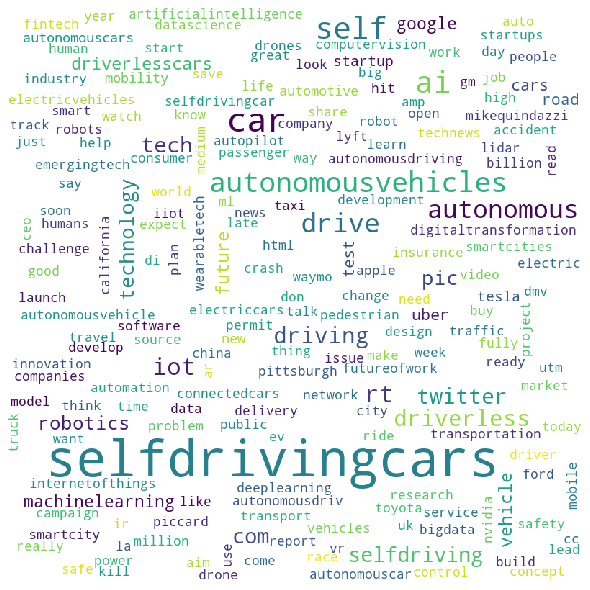

In [74]:
# Create word cloud with features
from wordcloud import WordCloud

count_vectorizer = CountVectorizer(min_df=4, max_df=0.9, lowercase="True", stop_words="english")   
cv_fit = count_vectorizer.fit_transform(data_frame.text.tolist())    
feature_list = count_vectorizer.get_feature_names()
feature_count_list = cv_fit.toarray().sum(axis=0)
frequencies_map = dict(zip(feature_list, feature_count_list))

wordcloud = WordCloud(width = 800, height = 800, 
                background_color = 'white', 
                min_font_size = 9).generate_from_frequencies(frequencies_map) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()  

In [75]:
# Creating feature vectors
from sklearn.feature_extraction.text import TfidfVectorizer

tdif_vectorizer = TfidfVectorizer(min_df=4, max_df=0.9, lowercase="True", stop_words="english")
transformed_data_X = tdif_vectorizer.fit_transform(data_frame.text.tolist())
transformed_data_X = transformed_data_X.toarray()

train_data_X = transformed_data_X[0:6966]
train_data_Y = data_frame.emotion.tolist()[0:6966]
test_data_X = transformed_data_X[6966:]
test_data_Y = data_frame.emotion.tolist()[6966:]
print(len(train_data_X), len(test_data_X))
print(len(train_data_Y), len(test_data_Y))
print(tdif_vectorizer.get_feature_names())
print(train_data_X.shape)
print(train_data_Y)

6966 7000
6966 7000
['aaa', 'aaaj', 'aapl', 'ab', 'abc', 'ability', 'able', 'abordar', 'ac', 'accelerate', 'accelerates', 'accelerator', 'accept', 'acceptance', 'access', 'accessibility', 'accident', 'accidents', 'accord', 'according', 'accordo', 'account', 'accuracy', 'accurate', 'achieve', 'acknowledge', 'acquire', 'acquisition', 'acre', 'act', 'action', 'activity', 'actually', 'ad', 'adapt', 'adaptive', 'adas', 'add', 'addition', 'address', 'adjust', 'administration', 'admit', 'adopt', 'adoption', 'adtech', 'advance', 'advanced', 'advancedtechnologies', 'advancement', 'advantage', 'advent', 'adversarial', 'advertise', 'affair', 'affect', 'affordable', 'afraid', 'age', 'aggressive', 'ago', 'agree', 'agreement', 'agriculture', 'aguggini', 'ah', 'ahead', 'ai', 'aid', 'aiethics', 'aim', 'aiming', 'air', 'aircraft', 'airless', 'airplanes', 'airport', 'aitrends', 'aitrendsinsider', 'aitrendsinsideronautonomy', 'aka', 'al', 'alarm', 'alex', 'alexa', 'alexander', 'algorithm', 'algorithms', 

In [76]:
# Training SVM classifier
from sklearn import svm

svm_classifier = svm.SVC(kernel="linear", verbose=3)
svm_classifier.fit(train_data_X, train_data_Y)

[LibSVM]

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=3)

In [79]:
# Train and test predictions
train_predictions_Y = list(svm_classifier.predict(train_data_X))
test_predictions_Y = list(svm_classifier.predict(test_data_X))

In [81]:
# Training/Testing accuracy score
from sklearn.metrics import accuracy_score

print("Train data accuracy:", accuracy_score(train_predictions_Y, train_data_Y) * 100)
print("Test data accuracy:", accuracy_score(test_predictions_Y, test_data_Y) * 100)

Train data accuracy: 90.25265575653172
Test data accuracy: 79.31428571428572


Counter({'neutral': 4313, 'positive': 2222, 'negative': 431})
Counter({'neutral': 3796, 'positive': 2541, 'negative': 629})


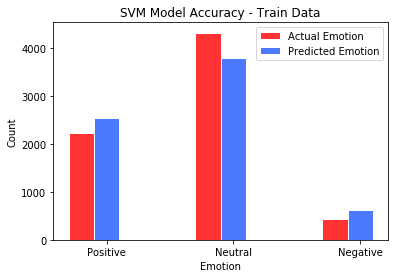

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

actual_train_counts = Counter(train_predictions_Y)
prediction_train_counts = Counter(train_data_Y)
print(actual_train_counts)
print(prediction_train_counts)

# set width of bar
barWidth = 0.20
 
# set height of bar
bars1 = [actual_train_counts['positive'], actual_train_counts['neutral'], actual_train_counts['negative']]
bars2 = [prediction_train_counts['positive'], prediction_train_counts['neutral'], prediction_train_counts['negative']]
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color='#ff3333', width=barWidth, edgecolor='white', label='Actual Emotion')
plt.bar(r2, bars2, color='#4d79ff', width=barWidth, edgecolor='white', label='Predicted Emotion')
 
# Add xticks/yticks on the middle of the group bars
plt.xlabel('Emotion')
plt.xticks([r + barWidth for r in range(len(bars1))], ['Positive', 'Neutral', 'Negative'])
plt.ylabel('Count')
plt.title('SVM Model Accuracy - Train Data')
 
# Create legend & Show graphic
plt.legend()
plt.show()

Counter({'neutral': 4251, 'positive': 2578, 'negative': 171})
Counter({'neutral': 3242, 'positive': 3232, 'negative': 526})


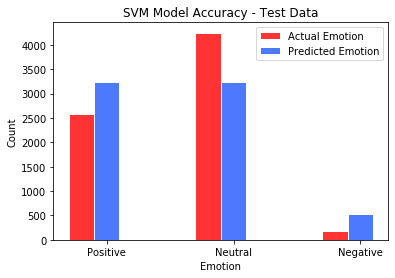

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

actual_test_counts = Counter(test_predictions_Y)
prediction_test_counts = Counter(test_data_Y)
print(actual_test_counts)
print(prediction_test_counts)

# set width of bar
barWidth = 0.20
 
# set height of bar
bars1 = [actual_test_counts['positive'], actual_test_counts['neutral'], actual_test_counts['negative']]
bars2 = [prediction_test_counts['positive'], prediction_test_counts['neutral'], prediction_test_counts['negative']]
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color='#ff3333', width=barWidth, edgecolor='white', label='Actual Emotion')
plt.bar(r2, bars2, color='#4d79ff', width=barWidth, edgecolor='white', label='Predicted Emotion')
 
# Add xticks/yticks on the middle of the group bars
plt.xlabel('Emotion')
plt.xticks([r + barWidth for r in range(len(bars1))], ['Positive', 'Neutral', 'Negative'])
plt.ylabel('Count')
plt.title('SVM Model Accuracy - Test Data')
 
# Create legend & Show graphic
plt.legend()
plt.show()